# Data format for Punctuation: Predictions

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

import warnings
warnings.filterwarnings('ignore')

### Importing data

In [2]:
df = pd.read_csv('../../data/clean/anx_writing.csv')
df.tail(2)

,Unnamed: 0,author,link_flair_text,num_comments,subreddit,created_utc,text
5998,2998,throwaway5820175,Advice,5,writing,1631759726,Possible copyright issues? I'm wanting to writ...
5999,2999,Longjumping-Celery54,Other,1,writing,1604277033,"A poem I wrote called ""Another World"" She wake..."


### Baseline Accuracy

In [3]:
df['subreddit'].value_counts(normalize = True)

writing    0.5
Anxiety    0.5
Name: subreddit, dtype: float64

### Adding stopwords

In [4]:
# Extending my list of stop words
stop_words = stopwords.words("english")
new_stop_words = ['like', 'just', 'don', 've', 'know', 'time', 'really', 
                'want', 'people', 'going', 'think', 'make', 'day', 
                'https', 'com', 'much', 'something', 'would', 'go',
               'even', 'things', 'also', 'got', 'www', 'could', 'take', 'anxiety', 'writer',
                 'ha', 'le', 'wa']
stop_words.extend(new_stop_words)

In [5]:
# Cleaning function
def custom_preprocessor (text):
    text = text.lower() #lowercases word
    text = re.sub(r'[0–9]', '', text) #removes any numbers
    text = re.sub('(<.*?>)', '', text) #removed html
    #copied from https://swatimeena989.medium.com/beginners-guide-for-preprocessing-text-data-f3156bec85ca
    
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    
    return text

#copied from https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

In [6]:
# Turn subreddit column to 1 if anxiety and 0 if writing.
df['subreddit'] = df['subreddit'].map({'Anxiety': 'Anxiety', 'writing': 'No Anxiety'})

### Modeling

In [7]:
X = df['text']
y = df['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7, stratify = y)

In [9]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words= stop_words, 
                             preprocessor = custom_preprocessor)),
    ('rf', RandomForestClassifier())  
])

In [10]:
pipe_params = {
    'tvec__max_features': [1000, 2000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,2), (2,2)],
    'rf__n_estimators': [80, 100],
    'rf__max_depth': [None, 1, 3, 5],
    'rf__max_features': ['sqrt', .5]
}

In [11]:
# Instantiate GridSearchCV.
rf_tvec = GridSearchCV(
    pipe,
    param_grid = pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose=1
)

In [12]:
# Fit GridSearch to training data.
rf_tvec.fit(X_train, y_train) 

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(preprocessor=<function custom_preprocessor at 0x7fd43e18ddc0>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                    

In [13]:
# Best parameters
rf_tvec.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 100,
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [14]:
# Best parameters
rf_tvec.best_params_
def model_metrics(model, X_train, X_test):
    
    print(f'Best Score: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    
model_metrics(rf_tvec, X_train, X_test)

Best Score: 0.959047619047619
Best Parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100, 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Train Score: 0.9976190476190476
Test Score: 0.9461111111111111


### Subreddit Prediction Evaluation ( Anxiety vs Writing )

In [15]:
#Function for plotting confusion matrix
def plot_matrix(model, X_test):
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # View confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap = 'copper', values_format='d', ax = ax)
    
    # Labels, title and ticks
    label_font = {'size':'15'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title('Confusion Matrix for Random Forest', fontdict=title_font, fontsize=15);

    ax.tick_params(axis='both', which='major', labelsize=12) 
    
#Copied from https://stackoverflow.com/questions/59839782/confusion-matrix-font-size

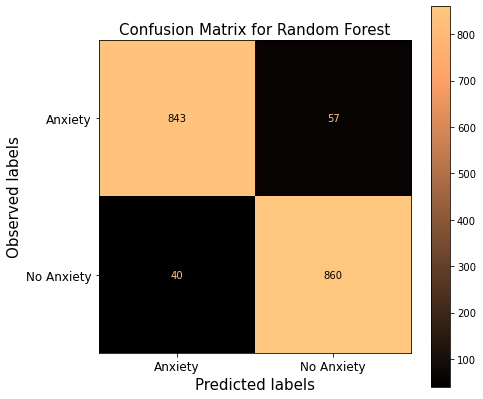

In [16]:
plot_matrix(rf_tvec, X_test)

In [17]:
# Get predictions
preds_tvec = rf_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity and precision
spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('specificity:', spec)
print('precision:', prec)

specificity: 0.9366666666666666
precision: 0.9378407851690295


In [18]:
pipe.named_steps

{'tvec': TfidfVectorizer(preprocessor=<function custom_preprocessor at 0x7fd43e18ddc0>,
                 stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                             'ourselves', 'you', "you're", "you've", "you'll",
                             "you'd", 'your', 'yours', 'yourself', 'yourselves',
                             'he', 'him', 'his', 'himself', 'she', "she's",
                             'her', 'hers', 'herself', 'it', "it's", 'its',
                             'itself', ...]),
 'rf': RandomForestClassifier()}

### Saving model

In [19]:
with open('./Random_Forest_punct.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pipe, pickle_out)